In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu.spatial_model

In [5]:
import scanpy as sc

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [6]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

In [7]:
adata.obsm['X_spatial']

array([[ -724.78798784,  -806.77627537],
       [  246.54489078,  1746.15047681],
       [ -117.64861008,  1048.86797915],
       ...,
       [ -636.30278025, -1247.58704544],
       [  661.78246634, -1333.19154819],
       [  812.89596752,  -815.81354621]])

In [8]:
train_Xs = []
train_Ds = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    mask = adata.obs['donor_slice'] == i
    train_Xs.append(np.array(adata.X[mask, :]))
    train_Ds.append(sklearn.metrics.pairwise_distances(adata.obsm['X_spatial'][mask, :]))
    
validate_Xs = []
validate_Ds = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    mask = adata.obs['donor_slice'] == i
    validate_Xs.append(np.array(adata.X[mask, :]))
    validate_Ds.append(sklearn.metrics.pairwise_distances(adata.obsm['X_spatial'][mask, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs, Ds):
        super(MyDataSet, self).__init__()
        assert(len(Xs) == len(Ds))
        self.Xs = [torch.Tensor(X) for X in Xs]
        self.Ds = [torch.Tensor(D) for D in Ds]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx], self.Ds[idx]

train_data = MyDataSet(train_Xs, train_Ds)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs, validate_Ds)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [9]:
np.quantile(train_Ds[0].flatten(), .1)

512.0258464258015

In [10]:
model = kuanglu.spatial_model.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_embed=[800, 200, 100], 
                      d_quality=[800, 200, 1], 
                      n_heads=3).to('cuda')

In [11]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 200],
                fix=['embed', 'qualify', 'smooth', 'interact'])

Epoch 0001 Train MSE 0.976 Validate MSE 1.033 Raw MSE 1.017
Epoch 0002 Train MSE 0.964 Validate MSE 1.026 Raw MSE 1.023
Epoch 0003 Train MSE 0.952 Validate MSE 1.010 Raw MSE 1.018
Epoch 0004 Train MSE 0.918 Validate MSE 0.995 Raw MSE 1.014
Epoch 0005 Train MSE 0.908 Validate MSE 0.976 Raw MSE 1.009
Epoch 0006 Train MSE 0.907 Validate MSE 0.997 Raw MSE 1.034
Epoch 0007 Train MSE 0.920 Validate MSE 0.956 Raw MSE 1.001
Epoch 0008 Train MSE 0.898 Validate MSE 0.986 Raw MSE 1.037
Epoch 0009 Train MSE 0.873 Validate MSE 0.915 Raw MSE 0.962
Epoch 0010 Train MSE 0.867 Validate MSE 0.932 Raw MSE 0.990
Epoch 0011 Train MSE 0.869 Validate MSE 0.946 Raw MSE 1.013
Epoch 0012 Train MSE 0.865 Validate MSE 0.937 Raw MSE 1.002
Epoch 0013 Train MSE 0.864 Validate MSE 0.943 Raw MSE 1.025
Epoch 0014 Train MSE 0.852 Validate MSE 0.956 Raw MSE 1.035
Epoch 0015 Train MSE 0.831 Validate MSE 0.927 Raw MSE 1.009
Epoch 0016 Train MSE 0.846 Validate MSE 0.927 Raw MSE 1.017
Epoch 0017 Train MSE 0.837 Validate MSE 

Epoch 0138 Train MSE 0.818 Validate MSE 0.924 Raw MSE 0.998
Epoch 0139 Train MSE 0.823 Validate MSE 0.923 Raw MSE 1.010
Epoch 0140 Train MSE 0.811 Validate MSE 0.923 Raw MSE 1.001
Epoch 0141 Train MSE 0.836 Validate MSE 0.921 Raw MSE 1.001
Epoch 0142 Train MSE 0.820 Validate MSE 0.901 Raw MSE 0.998
Epoch 0143 Train MSE 0.807 Validate MSE 0.936 Raw MSE 1.023
Epoch 0144 Train MSE 0.801 Validate MSE 0.910 Raw MSE 1.000
Epoch 0145 Train MSE 0.841 Validate MSE 0.922 Raw MSE 1.015
Epoch 0146 Train MSE 0.816 Validate MSE 0.892 Raw MSE 0.977
Epoch 0147 Train MSE 0.822 Validate MSE 0.905 Raw MSE 0.997
Epoch 0148 Train MSE 0.814 Validate MSE 0.906 Raw MSE 0.983
Epoch 0149 Train MSE 0.815 Validate MSE 0.923 Raw MSE 0.997
Epoch 0150 Train MSE 0.816 Validate MSE 0.942 Raw MSE 1.017
Epoch 0151 Train MSE 0.806 Validate MSE 0.936 Raw MSE 1.021
Epoch 0152 Train MSE 0.803 Validate MSE 0.919 Raw MSE 1.012
Epoch 0153 Train MSE 0.832 Validate MSE 0.914 Raw MSE 1.006
Epoch 0154 Train MSE 0.828 Validate MSE 

In [12]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [200, 250],
                                           fix=['denoise', 'interact']))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [250, 400],
                                           fix=['interact']))

Epoch 0201 Train MSE 0.929 Validate MSE 0.947 Raw MSE 1.021
Epoch 0202 Train MSE 0.870 Validate MSE 0.916 Raw MSE 1.005
Epoch 0203 Train MSE 0.850 Validate MSE 0.904 Raw MSE 1.017
Epoch 0204 Train MSE 0.844 Validate MSE 0.916 Raw MSE 1.028
Epoch 0205 Train MSE 0.843 Validate MSE 0.907 Raw MSE 1.003
Epoch 0206 Train MSE 0.842 Validate MSE 0.905 Raw MSE 0.974
Epoch 0207 Train MSE 0.822 Validate MSE 0.886 Raw MSE 0.991
Epoch 0208 Train MSE 0.811 Validate MSE 0.906 Raw MSE 1.011
Epoch 0209 Train MSE 0.829 Validate MSE 0.888 Raw MSE 0.999
Epoch 0210 Train MSE 0.819 Validate MSE 0.908 Raw MSE 0.984
Epoch 0211 Train MSE 0.849 Validate MSE 0.896 Raw MSE 0.979
Epoch 0212 Train MSE 0.826 Validate MSE 0.875 Raw MSE 0.982
Epoch 0213 Train MSE 0.826 Validate MSE 0.896 Raw MSE 1.021
Epoch 0214 Train MSE 0.810 Validate MSE 0.906 Raw MSE 1.007
Epoch 0215 Train MSE 0.815 Validate MSE 0.904 Raw MSE 0.998
Epoch 0216 Train MSE 0.812 Validate MSE 0.891 Raw MSE 0.994
Epoch 0217 Train MSE 0.817 Validate MSE 

Epoch 0338 Train MSE 0.782 Validate MSE 0.848 Raw MSE 1.022
Epoch 0339 Train MSE 0.798 Validate MSE 0.848 Raw MSE 1.013
Epoch 0340 Train MSE 0.776 Validate MSE 0.860 Raw MSE 1.013
Epoch 0341 Train MSE 0.794 Validate MSE 0.817 Raw MSE 0.978
Epoch 0342 Train MSE 0.787 Validate MSE 0.869 Raw MSE 1.037
Epoch 0343 Train MSE 0.791 Validate MSE 0.858 Raw MSE 1.035
Epoch 0344 Train MSE 0.786 Validate MSE 0.878 Raw MSE 1.025
Epoch 0345 Train MSE 0.788 Validate MSE 0.851 Raw MSE 1.011
Epoch 0346 Train MSE 0.786 Validate MSE 0.849 Raw MSE 1.009
Epoch 0347 Train MSE 0.809 Validate MSE 0.845 Raw MSE 1.003
Epoch 0348 Train MSE 0.792 Validate MSE 0.828 Raw MSE 0.988
Epoch 0349 Train MSE 0.794 Validate MSE 0.821 Raw MSE 0.971
Epoch 0350 Train MSE 0.812 Validate MSE 0.856 Raw MSE 1.014
Epoch 0351 Train MSE 0.796 Validate MSE 0.857 Raw MSE 1.023
Epoch 0352 Train MSE 0.791 Validate MSE 0.830 Raw MSE 0.977
Epoch 0353 Train MSE 0.791 Validate MSE 0.827 Raw MSE 0.980
Epoch 0354 Train MSE 0.777 Validate MSE 

In [13]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [400, 450],
                                           fix=['denoise', 'embed', 'qualify', 'smooth']))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [450, 600]))

Epoch 0401 Train MSE 0.803 Validate MSE 0.860 Raw MSE 1.009
Epoch 0402 Train MSE 0.814 Validate MSE 0.842 Raw MSE 1.008
Epoch 0403 Train MSE 0.824 Validate MSE 0.840 Raw MSE 1.016
Epoch 0404 Train MSE 0.816 Validate MSE 0.883 Raw MSE 1.012
Epoch 0405 Train MSE 0.814 Validate MSE 0.885 Raw MSE 1.043
Epoch 0406 Train MSE 0.805 Validate MSE 0.849 Raw MSE 0.996
Epoch 0407 Train MSE 0.818 Validate MSE 0.898 Raw MSE 1.046
Epoch 0408 Train MSE 0.801 Validate MSE 0.846 Raw MSE 0.995
Epoch 0409 Train MSE 0.818 Validate MSE 0.870 Raw MSE 1.024
Epoch 0410 Train MSE 0.814 Validate MSE 0.856 Raw MSE 1.022
Epoch 0411 Train MSE 0.803 Validate MSE 0.862 Raw MSE 1.030
Epoch 0412 Train MSE 0.804 Validate MSE 0.875 Raw MSE 1.022
Epoch 0413 Train MSE 0.819 Validate MSE 0.872 Raw MSE 1.009
Epoch 0414 Train MSE 0.802 Validate MSE 0.848 Raw MSE 1.022
Epoch 0415 Train MSE 0.811 Validate MSE 0.859 Raw MSE 1.014
Epoch 0416 Train MSE 0.809 Validate MSE 0.869 Raw MSE 1.043
Epoch 0417 Train MSE 0.814 Validate MSE 

Epoch 0538 Train MSE 0.809 Validate MSE 0.848 Raw MSE 1.002
Epoch 0539 Train MSE 0.788 Validate MSE 0.839 Raw MSE 1.004
Epoch 0540 Train MSE 0.802 Validate MSE 0.819 Raw MSE 0.991
Epoch 0541 Train MSE 0.792 Validate MSE 0.859 Raw MSE 1.035
Epoch 0542 Train MSE 0.772 Validate MSE 0.878 Raw MSE 1.055
Epoch 0543 Train MSE 0.782 Validate MSE 0.836 Raw MSE 1.002
Epoch 0544 Train MSE 0.784 Validate MSE 0.867 Raw MSE 1.023
Epoch 0545 Train MSE 0.788 Validate MSE 0.851 Raw MSE 1.003
Epoch 0546 Train MSE 0.795 Validate MSE 0.839 Raw MSE 1.021
Epoch 0547 Train MSE 0.782 Validate MSE 0.844 Raw MSE 1.006
Epoch 0548 Train MSE 0.802 Validate MSE 0.855 Raw MSE 1.035
Epoch 0549 Train MSE 0.799 Validate MSE 0.839 Raw MSE 1.001
Epoch 0550 Train MSE 0.781 Validate MSE 0.824 Raw MSE 0.989
Epoch 0551 Train MSE 0.775 Validate MSE 0.831 Raw MSE 0.999
Epoch 0552 Train MSE 0.773 Validate MSE 0.817 Raw MSE 0.979
Epoch 0553 Train MSE 0.763 Validate MSE 0.819 Raw MSE 0.977
Epoch 0554 Train MSE 0.778 Validate MSE 

Text(0, 0.5, 'MSE')

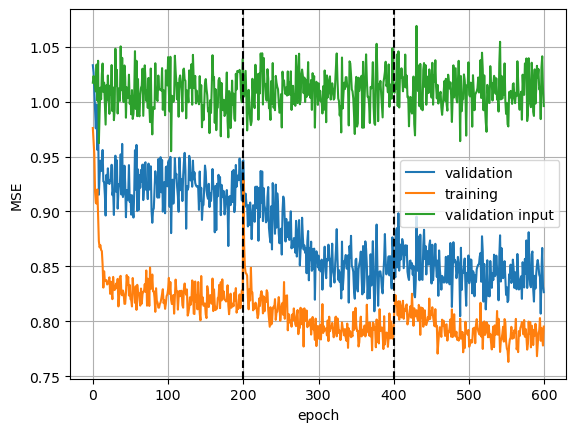

In [14]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(200, ls='--', c='k')
plt.axvline(400, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [15]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 100: return 'pre-denoise'
    elif x < 200: return 'denoise'
    elif x < 300: return 'pre-denoise-smooth'
    elif x < 400: return 'denoise-smooth'
    elif x < 500: return 'pre-denoise-smooth-enhance'
    elif x < 600: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 400 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

,epoch,mse,stage
0,0,1.033192,pre-denoise
1,1,1.026495,pre-denoise
2,2,1.010358,pre-denoise
3,3,0.994793,pre-denoise
4,4,0.975712,pre-denoise
...,...,...,...
595,595,0.806965,denoise-smooth-enhance
596,596,0.845833,denoise-smooth-enhance
597,597,0.866795,denoise-smooth-enhance
598,598,0.831876,denoise-smooth-enhance


C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\torch_2.0.1\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


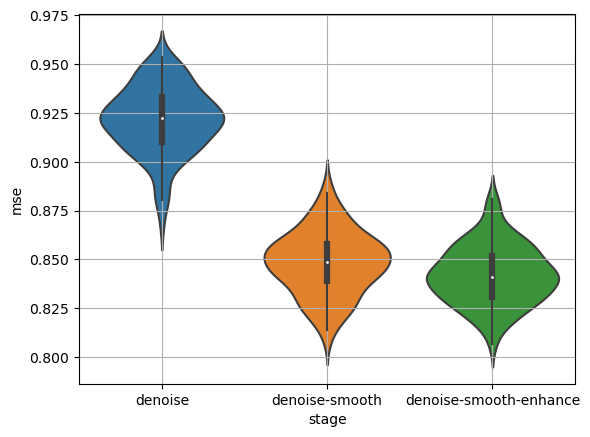

In [16]:
sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
plt.grid()

In [17]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 4.396007364960204e-34 f = 0.9982


In [18]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 0.005740430502317933 f = 0.6131


In [19]:
model.cell_interacts[0].spatial_scale

Parameter containing:
tensor(19.4353, device='cuda:0', requires_grad=True)

In [20]:
model.cell_interacts[1].spatial_scale

Parameter containing:
tensor(19.4401, device='cuda:0', requires_grad=True)

In [21]:
model.cell_interacts[2].spatial_scale

Parameter containing:
tensor(19.4323, device='cuda:0', requires_grad=True)